In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

#### Disable auto scrolling of output

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Global Settings

In [3]:
# Set low mass limits for clouds
lowLim512  = 8.  # Still tbd
lowLim1024 = 4.  # Still tbd
lowLim2048 = 1.

# Choose which columns we're interested in, i.e. which 'features' we want to investigate
pairPlotColumns = ['volume',  'mass', 'rPosition', 'zPositionAbs', 'polarAngle', 'vMag', 'time']

# Testing
testing = False  # If true plot only the different styles of plots. If false only plot the 3 different resolutions in the chosen style

# Import and setup Dataframes

In [4]:
# Load the datasets and print headers
catalog512 = np.load('../data/physCatalog512.npy')
catalog1024 = np.load('../data/physCatalog1024.npy')
catalog2048 = np.load('../data/physCatalog2048.npy')

In [5]:
# Convert to dataframes with mass, volume, radial distance, and magnitude of velocity

# ==============================================================================
def converter(catalog, lowLim):
    # Copy data to the dataFrame
    outputDF = pd.DataFrame()
    
    outputDF['ID']         = catalog['ID']
    outputDF['volume']     = catalog['volume']
    outputDF['mass']       = catalog['mass']
    outputDF['rPosition']  = np.sqrt(catalog['positionX']**2 
                                     + catalog['positionY']**2 
                                     + catalog['positionZ']**2)
    outputDF['zPosition']    = catalog['positionZ'].reshape(-1, 1)
    outputDF['zPositionAbs'] = np.abs(outputDF['zPosition'])
    outputDF['vMag']         = np.sqrt(catalog['velocityX']**2 
                                     + catalog['velocityY']**2 
                                     + catalog['velocityZ']**2)
    outputDF['polarAngle'] = np.arccos(np.abs(outputDF['zPosition'])/outputDF['rPosition'])
    outputDF['resolution'] = catalog['resolution']
    outputDF['time']       = catalog['time']
    
    # Cut out the low mass clouds that are poorly sampled
    catalog = catalog[catalog['mass'] > lowLim]

    return outputDF
# ==============================================================================

processed512  = converter(catalog512,  lowLim512)
processed1024 = converter(catalog1024, lowLim1024)
processed2048 = converter(catalog2048, lowLim2048)

# Start Plotting 

## Different plot styles

### Scatter/Histogram

Works ok, it's hard to see contours though

In [6]:
if testing:
    # Setup the plot and return the plot object
    figGrid = sns.pairplot(processed512[pairPlotColumns].sample(1000),
                           kind      = 'scatter',
                           diag_kind = 'hist',
                           corner    = True,
                           hue       = 'time',
                           palette   = 'flare',
                           plot_kws  ={'alpha': 0.2})

    # Set all axis to log log scale
    a,b = figGrid.axes.shape
    for i in range(a):
        for j in range(b):
            try:
                figGrid.axes[i,j].set_xscale('log')
                figGrid.axes[i,j].set_yscale('log')
            except AttributeError:
                pass

    plt.show()

### KDE/KDE

Probably the best option. Clear contours

In [7]:
if testing:
    # Setup the plot and return the plot object
    figGrid = sns.pairplot(processed512[pairPlotColumns].sample(1000),
                           kind   = 'kde',
                           corner = True)

    # Set all axis to log log scale
    for i in range(2):
        for j in range(2):
            try:
                figGrid.axes[i,j].set_xscale('log')
                figGrid.axes[i,j].set_yscale('log')
            except AttributeError:
                pass

    plt.show()

### Univariate Histogram/Histogram

Better than the scatter plots but still hard to see the contours

In [8]:
if testing:
    # Setup the plot and return the plot object
    figGrid = sns.pairplot(processed512[pairPlotColumns].sample(1000),
                           kind      = 'hist',
                           diag_kind = 'hist',
                           corner    = True,
                           hue       = 'time',
                           palette   = 'flare')

    #                        kind      = ,
    #                        diag_kind = ,

    # Set all axis to log log scale
    a,b = figGrid.axes.shape
    for i in range(a):
        for j in range(b):
            try:
                figGrid.axes[i,j].set_xscale('log')
                figGrid.axes[i,j].set_yscale('log')
            except AttributeError:
                pass

    plt.show()

# Plotting

## 512

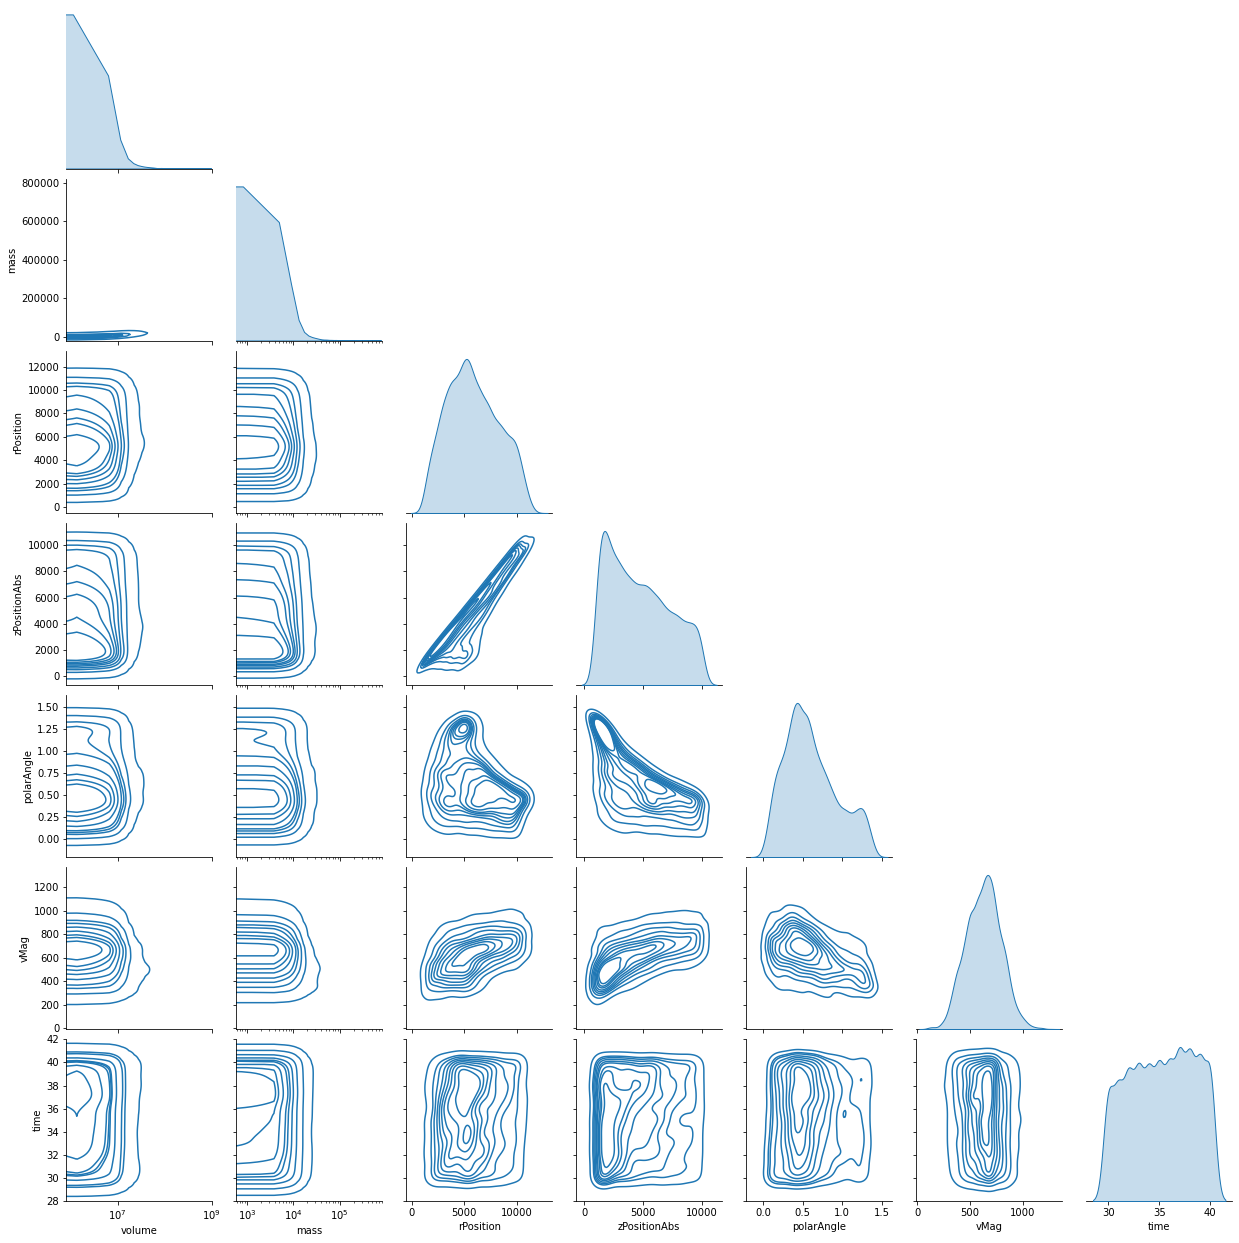

In [44]:
if not testing:
    # Setup the plot and return the plot object
    figGrid = sns.pairplot(processed512[pairPlotColumns].sample(10000),
                           kind   = 'kde',
                           corner = True)

    # Set all axis to log log scale
    for i in range(2):
        for j in range(2):
            try:
                figGrid.axes[i,j].set_xscale('log')
#                 figGrid.axes[i,j].set_yscale('log')
            except AttributeError:
                pass

    plt.savefig("../figures/pairPlots/512-KDE.pdf")
    plt.show()

## 1024

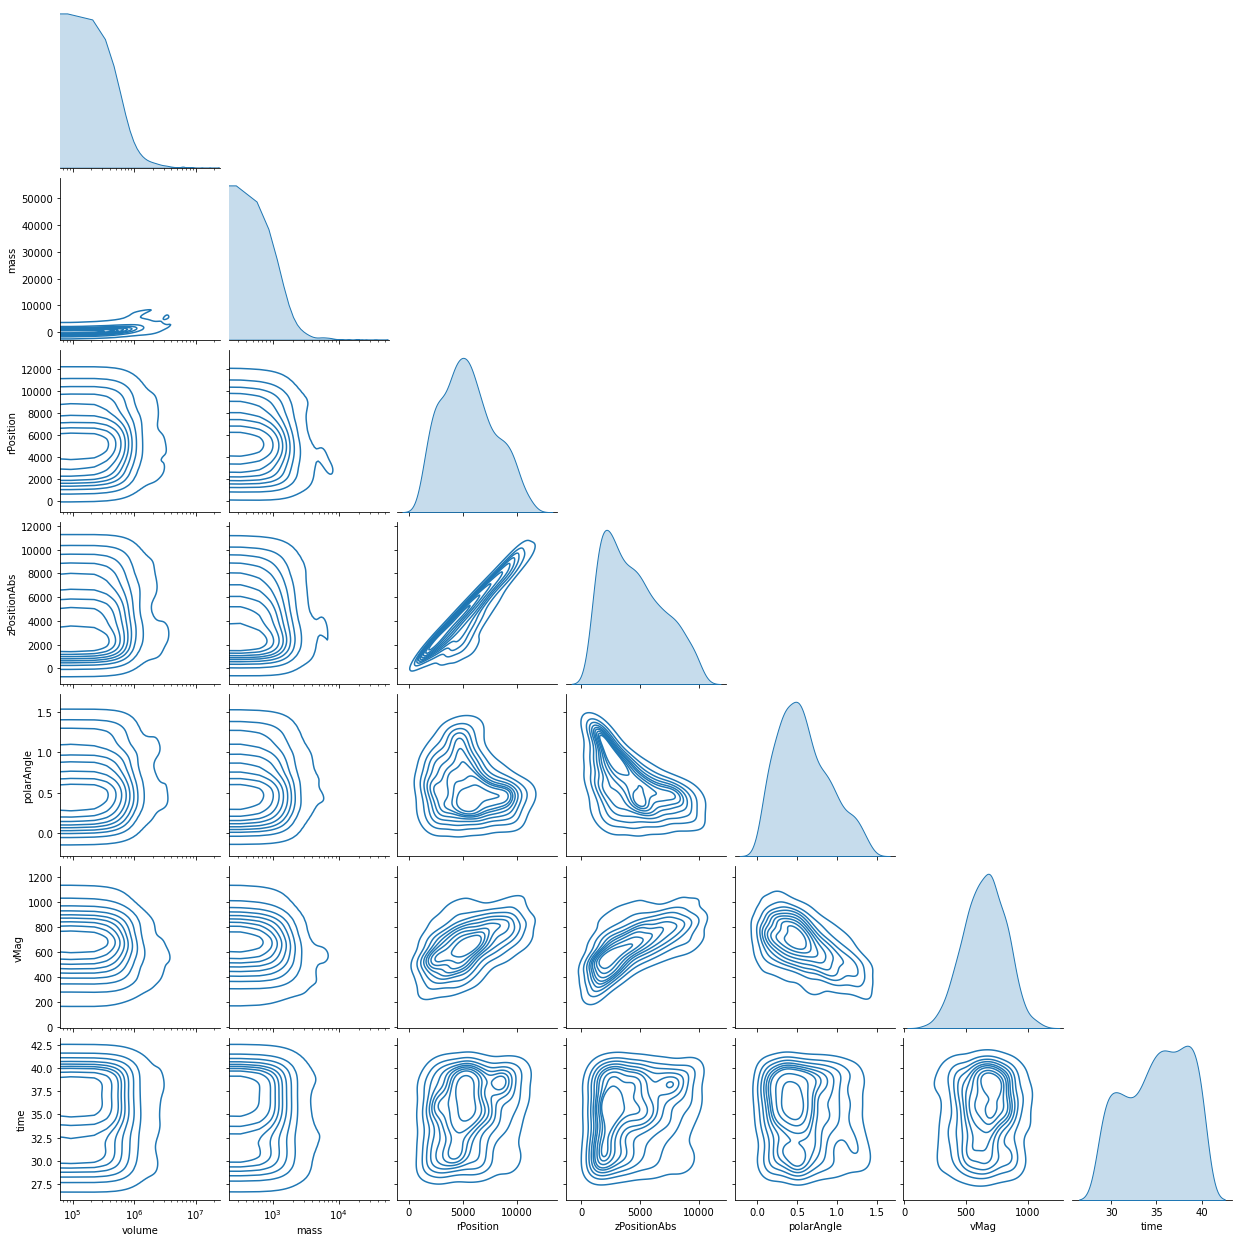

In [46]:
if not testing:
    # Setup the plot and return the plot object
    figGrid = sns.pairplot(processed1024[pairPlotColumns].sample(1000),
                           kind   = 'kde',
                           corner = True)

    # Set all axis to log log scale
    for i in range(2):
        for j in range(2):
            try:
                figGrid.axes[i,j].set_xscale('log')
#                 figGrid.axes[i,j].set_yscale('log')
            except AttributeError:
                pass

    plt.savefig("../figures/pairPlots/1024-KDE.pdf")
    plt.show()

## 2048

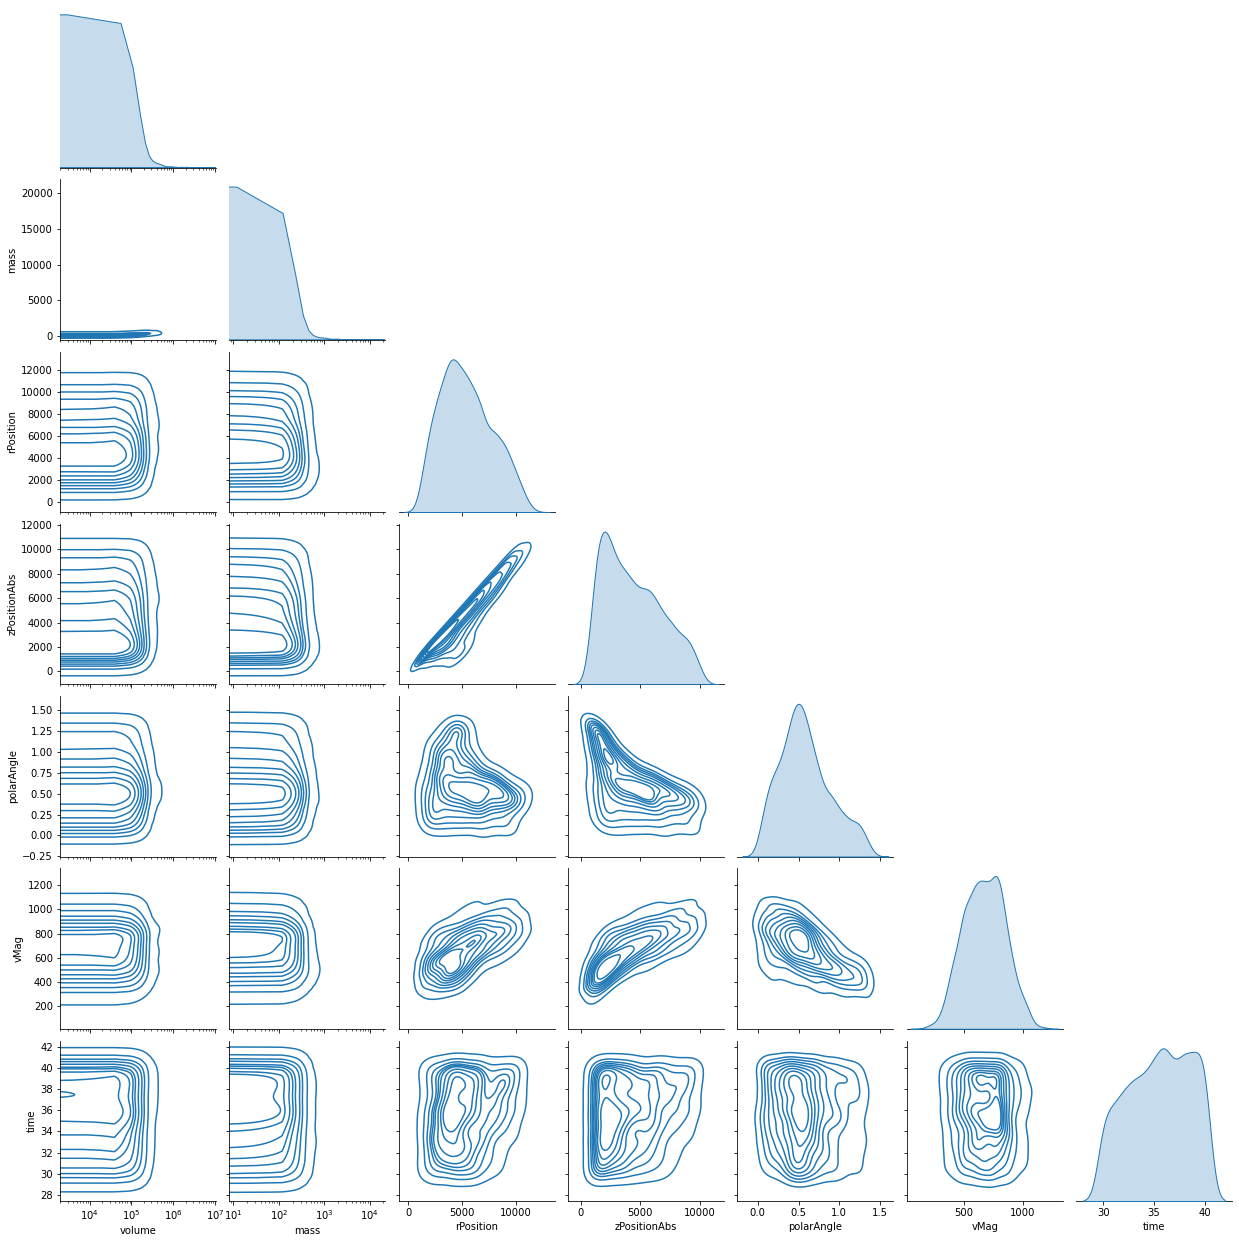

In [43]:
if not testing:
    # Setup the plot and return the plot object
    figGrid = sns.pairplot(processed2048[pairPlotColumns].sample(2000),
                           kind   = 'kde',
                           corner = True)

    # Set all axis to log log scale
    for i in range(2):
        for j in range(2):
            try:
                figGrid.axes[i,j].set_xscale('log')
#                 figGrid.axes[i,j].set_yscale('log')
            except AttributeError:
                pass

    plt.savefig("../figures/pairPlots/2048-KDE.pdf")
    plt.show()